In [ ]:
%matplotlib inline
#%matplotlib notebook
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,8)
import pylab as plt
from astrometry.libkd.spherematch import *
from astrometry.util.fits import *
import numpy as np
from astrometry.util.starutil_numpy import *
from astrometry.util.plotutils import *
from glob import glob

In [2]:
T=fits_table('~/cosmo/data/wise/merge/merge_p1bm_frm/WISE-l1b-metadata-neowiser.fits')
T.cut(np.argsort(T.mjd))

In [3]:
#plt.plot(T.ra0[I], T.dec0[I], 'b.')
#plt.plot(T.ecl_l[I], T.ecl_b[I], 'b.')

In [4]:
T.ecl_l,T.ecl_b = radectoecliptic(T.ra0, T.dec0)
J1=np.flatnonzero((np.abs(T.mjd - 56708) < 5.) * (T.ecl_b < -89.3))

In [5]:
from astrometry.util.util import Tan, Sip
from unwise_coadd import *
# SEP!
wcs = get_coadd_tile_wcs(90.0, -66.56)

In [13]:
from astrometry.util.resample import *
scans = np.unique(T.scan_id[J1])
print(len(scans), 'scans')
#scans = [scans[i] for i in ]
doscans = [0,1,19,20,40,41,99,100]#,118,119]#139,140]
coimgs = {}
for iscan,scan in enumerate(scans):
    if not iscan in doscans:
        continue
    print('Scan', iscan)
    K = J1[T.scan_id[J1] == scan]
    coimg = np.zeros(wcs.shape, np.float32)
    con = np.zeros(wcs.shape, np.uint8)
    for k in K:
        frame = T[k]
        fn = get_l1b_file('/global/homes/d/dstn/cosmo/data/wise/merge/merge_p1bm_frm/', frame.scan_id, frame.frame_num, 1)
        print(fn)
        img = fitsio.read(fn)
        ok = np.isfinite(img)
        med = np.percentile(img[ok], 50)
        img[ok==False] = med
        imgwcs = Sip(fn)
        #ok,x,y = imgwcs.radec2pixelxy(90.74254187941929, -66.69918917807308)
        #print('->', int(x), int(y))
        Yo,Xo,Yi,Xi,[rimg] = resample_with_wcs(wcs, imgwcs, [img-med], 3)
        coimg[Yo,Xo] += rimg
        con[Yo,Xo] += 1
    coimg /= np.maximum(con, 1)
    coimgs[iscan] = coimg
    plt.imsave('coimg-%03i.png' % iscan, coimg, origin='lower', vmin=0, vmax=25)
    #if iscan == 19:
    #    break

142 scans
Scan 0
/global/homes/d/dstn/cosmo/data/wise/merge/merge_p1bm_frm/2a/46132a/269/46132a269-w1-int-1b.fits
/global/homes/d/dstn/cosmo/data/wise/merge/merge_p1bm_frm/2a/46132a/270/46132a270-w1-int-1b.fits
Scan 1
/global/homes/d/dstn/cosmo/data/wise/merge/merge_p1bm_frm/4b/46134b/010/46134b010-w1-int-1b.fits
/global/homes/d/dstn/cosmo/data/wise/merge/merge_p1bm_frm/4b/46134b/011/46134b011-w1-int-1b.fits
Scan 19
/global/homes/d/dstn/cosmo/data/wise/merge/merge_p1bm_frm/2a/46172a/270/46172a270-w1-int-1b.fits
/global/homes/d/dstn/cosmo/data/wise/merge/merge_p1bm_frm/2a/46172a/271/46172a271-w1-int-1b.fits
Scan 20
/global/homes/d/dstn/cosmo/data/wise/merge/merge_p1bm_frm/4a/46174a/009/46174a009-w1-int-1b.fits
/global/homes/d/dstn/cosmo/data/wise/merge/merge_p1bm_frm/4a/46174a/010/46174a010-w1-int-1b.fits
Scan 40
/global/homes/d/dstn/cosmo/data/wise/merge/merge_p1bm_frm/6a/46216a/270/46216a270-w1-int-1b.fits
/global/homes/d/dstn/cosmo/data/wise/merge/merge_p1bm_frm/6a/46216a/271/46216a2

In [14]:
medimg = np.median(np.dstack(coimgs.values()), axis=2)
maximg = np.max(np.dstack(coimgs.values()), axis=2)

In [ ]:
plt.imshow(medimg, interpolation='nearest', origin='lower', vmin=0, vmax=25);
plt.axis([500,750,750,1000]);

In [ ]:
plt.imshow(maximg-medimg, interpolation='nearest', origin='lower', vmin=0, vmax=25);
plt.axis([500,750,750,1000]);

In [17]:
coords = {
    0: (692,802),
    1: (641,837),
    19: (674,817),
    20: (621,849),
    40: (652,832),
    41: (599,864),
    99: (587,869),
    100: (531,896),
    #118: (600,850),
}

[0, 1, 19, 20, 40, 41, 99, 100, 118, 119]
Closest: 614 856


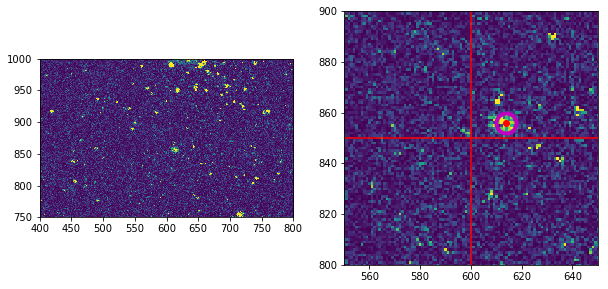

In [18]:
# For finding "coords" in the first place...
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.measurements import label, find_objects
print(doscans)
iscan = 118
plt.subplot(1,2,1)
plt.imshow(np.abs(coimgs[iscan]-medimg), interpolation='nearest', origin='lower', vmin=0, vmax=25);

det = gaussian_filter(coimgs[iscan]-medimg, 2.)
hot = (det > 5.)
blobs,nblobs = label(hot)
slices = find_objects(blobs)
xx,yy = np.zeros(nblobs, int), np.zeros(nblobs, int)
for i,(blob,slc) in enumerate(zip(blobs,slices)):
    sub = det[slc]
    #print('blob values within', i, np.unique(blobs[slc]))
    sub *= (blobs[slc] == (i+1))
    y0,x0 = slc[0].start, slc[1].start
    my,mx = np.unravel_index(np.argmax(sub), sub.shape)
    xx[i] = x0+mx
    yy[i] = y0+my

plt.axis([400,800,750,1000]);
plt.subplot(1,2,2)

x,y = coords[iscan]

closest = np.argmin(np.hypot(xx - x, yy - y))
plt.imshow(np.abs(coimgs[iscan]-medimg), interpolation='nearest', origin='lower', vmin=0, vmax=25);
plt.plot(xx, yy, 'ro')
plt.plot(xx[closest], yy[closest], 'mo', ms=20, mew=4, mfc='none')
print('Closest:', xx[closest], yy[closest])
plt.axvline(x, color='r')
#plt.axvline(x-5, color='r')
#plt.axvline(x+5, color='r')
plt.axhline(y, color='r')
#plt.axhline(y-5, color='r')
#plt.axhline(y+5, color='r')
plt.axis([x-50,x+50, y-50, y+50]);

In [ ]:
# Find out the specific L1b image containing the RA,Dec point in each scan.
auinkm = 1.5e8
fns = {}
scanwcs = {}
scandates = {}
framemeta = {}
scpos = {}
dirs = {}
sctracks = {}
for iscan in doscans:
    print('Scan', iscan)
    scan = scans[iscan]
    K = J1[T.scan_id[J1] == scan]
    for k in K:
        frame = T[k]
        fn = get_l1b_file('/global/homes/d/dstn/cosmo/data/wise/merge/merge_p1bm_frm/', frame.scan_id, frame.frame_num, 1)
        print(fn)
        imgwcs = Sip(fn)
        ok,x,y = imgwcs.radec2pixelxy(90.74254187941929, -66.69918917807308)
        H,W = imgwcs.shape
        if not(x >= 1 and y >= 1 and x <= W and y <= H):
            continue
        print('->', int(x), int(y))
        fns[iscan] = fn
        scanwcs[iscan] = imgwcs    
        hdr = fitsio.read_header(fn)
        scandates[iscan] = hdr['DATE_OBS']
        scpos[iscan] = auinkm * np.array([hdr['ERTH2SCX'],hdr['ERTH2SCY'],hdr['ERTH2SCZ']])
        x,y = coords[iscan]
        r,d = wcs.pixelxy2radec(x+1, y+1)
        dirs[iscan] = radectoxyz(r,d)[0]
        framemeta[iscan] = frame
        track = []
        for fnum in range(frame.frame_num - 100, frame.frame_num + 101, 10):
            fn = get_l1b_file('/global/homes/d/dstn/cosmo/data/wise/merge/merge_p1bm_frm/', frame.scan_id, fnum, 1)
            if not os.path.exists(fn):
                continue
            hdr = fitsio.read_header(fn)
            track.append(auinkm * np.array([hdr['ERTH2SCX'],hdr['ERTH2SCY'],hdr['ERTH2SCZ']]))
        sctracks[iscan] = np.vstack(track)
        break
            

In [ ]:
#%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import spring as cmap
import matplotlib.cm as cm
fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
ax = plt.gcf().add_subplot(111, projection='3d')

R_e = 6370.
u = np.linspace(0, 2 * np.pi, 21)
v = np.linspace(0, np.pi / 2., 7)
x = R_e * np.outer(np.cos(u), np.sin(v))
y = R_e * np.outer(np.sin(u), np.sin(v))
z = R_e * -np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_wireframe(x, y, z, color='k', alpha=0.2)

for ii,iscan in enumerate(doscans):
    f = float(ii) / (len(doscans)-1)
    cc = cmap(f)
    sc = scpos[iscan]
    d1 = scpos[iscan] + dirs[iscan]*1000.
    track = sctracks[iscan]
    ax.plot3D(track[:,0], track[:,1], track[:,2], '-', color=cc)
    ax.plot3D([sc[0]], [sc[1]], [sc[2]], 'o', color=cc, label='%s (scan %s)'%(scandates[iscan][:19], framemeta[iscan].scan_id))
    ax.plot3D([sc[0],d1[0]], [sc[1],d1[1]], [sc[2],d1[2]], '-', color=cc)
#ax.plot3D([0],[0],[0], 'ro')
plt.legend(loc='upper right')
for i,angle in enumerate(np.linspace(0, 360, 60, endpoint=False)):
    ax.view_init(30, angle)
    ax.axis('equal')
    plt.savefig('rotate-%03i.png' % i)
    print(i)
    #plt.draw()
    #plt.pause(.001)

In [ ]:
ax.set_position?

In [ ]:

'''
SUN2SCX =    -0.81955005972593 / [AU] Sun-to-S/C vector X component, J2000
SUN2SCY =    0.505716170733614 / [AU] Sun-to-S/C vector Y component, J2000
SUN2SCZ =     0.21919071289506 / [AU] Sun-to-S/C vector Z component, J2000
SCVELX  = -0.00743308810283315 / [AU/day] SUN-to-S/C velocity vector X component
SCVELY  =  -0.0097310164738194 / [AU/day] SUN-to-S/C velocity vector Y component
SCVELZ  = -0.00445218519404931 / [AU/day] SUN-to-S/C velocity vector Z component
ERTH2SCX= 2.39242578775712E-06 / [AU] Earth-to-S/C vector X component
ERTH2SCY= 1.42680866487827E-05 / [AU] Earth-to-S/C vector Y component
ERTH2SCZ= -4.37456411757718E-05 / [AU] Earth-to-S/C vector Z component

GEOLON  =           275.157902 / [deg] S/C geographic longitude
GEOLAT  =           -71.497494 / [deg] S/C geographic latitude
GEOALT  =           533.749211 / [km] S/C altitude
''';

In [ ]:
fn1 = '/global/homes/d/dstn/cosmo/data/wise/merge/merge_p1bm_frm/2a/46132a/269/46132a269-w1-int-1b.fits'
fn2 = '/global/homes/d/dstn/cosmo/data/wise/merge/merge_p1bm_frm/4b/46134b/010/46134b010-w1-int-1b.fits'
fn19 = '/global/homes/d/dstn/cosmo/data/wise/merge/merge_p1bm_frm/2a/46172a/270/46172a270-w1-int-1b.fits'
wcs1 = Sip(fn1)
wcs2 = Sip(fn2)
wcs19 = Sip(fn19)
hdr1 = fitsio.read_header(fn1)
hdr2 = fitsio.read_header(fn2)
hdr19 = fitsio.read_header(fn19)
#ra1,dec1 = wcs.pixelxy2radec(690, 810)
#ra2,dec2 = wcs.pixelxy2radec(640, 840)
ra1,dec1 = wcs1.pixelxy2radec(593, 32)
ra2,dec2 = wcs2.pixelxy2radec(671, 674)
ra19,dec19 = wcs19.pixelxy2radec(623, 492)
print(hdr1['DATE_OBS'], hdr2['DATE_OBS'], hdr19['DATE_OBS'])

In [ ]:

sc1 = auinkm * np.array([hdr1['ERTH2SCX'],hdr1['ERTH2SCY'],hdr1['ERTH2SCZ']])
dir1 = radectoxyz(ra1,dec1)[0]
sc2 = auinkm * np.array([hdr2['ERTH2SCX'],hdr2['ERTH2SCY'],hdr2['ERTH2SCZ']])
dir2 = radectoxyz(ra2,dec2)[0]
sc19 = auinkm * np.array([hdr19['ERTH2SCX'],hdr19['ERTH2SCY'],hdr19['ERTH2SCZ']])
dir19 = radectoxyz(ra19,dec19)[0]

In [ ]:
print(np.sqrt(np.sum((sc1 - sc2)**2)) * 1.5e8)
dir1
sc1

In [ ]:
#%matplotlib notebook
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
ax = plt.gcf().add_subplot(111, projection='3d')
d1 = sc1 + dir1*1000.
d2 = sc2 + dir2*1000.
d19 = sc19 + dir19*1000.
ax.plot3D([sc1[0]], [sc1[1]], [sc1[2]], 'bo')
ax.plot3D([sc1[0],d1[0]], [sc1[1],d1[1]], [sc1[2],d1[2]], 'b-')
ax.plot3D([sc2[0]], [sc2[1]], [sc2[2]], 'go')
ax.plot3D([sc2[0],d2[0]], [sc2[1],d2[1]], [sc2[2],d2[2]], 'g-')
ax.plot3D([sc19[0]], [sc19[1]], [sc19[2]], 'mo')
ax.plot3D([sc19[0],d19[0]], [sc19[1],d19[1]], [sc19[2],d19[2]], 'm-')
ax.plot3D([0],[0],[0], 'ro')
plt.show()

In [ ]:
dir1, dir2

In [ ]:
sc1,sc2

In [ ]:
auinkm = 1.5e8
sc1km = sc1 * auinkm
sc2km = sc2 * auinkm
dists = np.linspace(0, 2500., 100)
seps = np.zeros_like(dists)
for i,d in enumerate(dists):
    seps[i] = np.sqrt(np.sum(((sc1km + d*dir1) - (sc2km + d*dir2))**2))

In [ ]:
%matplotlib inline
plt.plot(dists, seps, 'b-')
plt.show()

In [ ]:
min(seps)